##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-09-15 15:19:05.075311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download and explore the dataset

In [3]:
print(tf.__version__)


2.13.0


This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

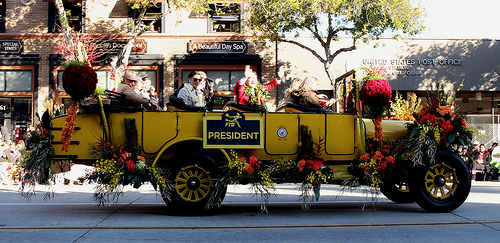

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

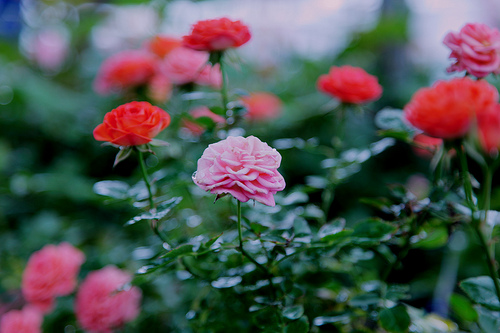

In [7]:
PIL.Image.open(str(roses[1]))

And some tulips:

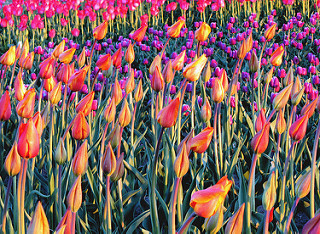

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

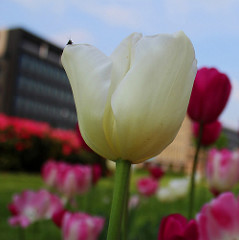

In [9]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

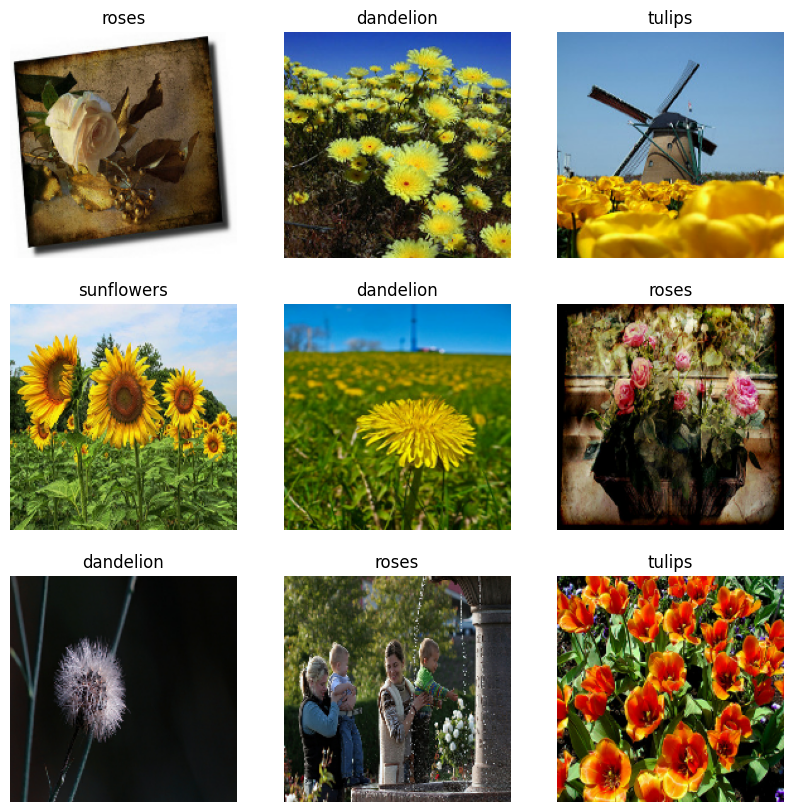

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [17]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 46s 483ms/step - loss: 1.2493 - accuracy: 0.4830 - val_loss: 1.0550 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 45s 486ms/step - loss: 0.9349 - accuracy: 0.6291 - val_loss: 1.0149 - val_accuracy: 0.6308
Epoch 3/10
92/92 [==============================] - 41s 442ms/step - loss: 0.7657 - accuracy: 0.7095 - val_loss: 0.8887 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 45s 487ms/step - loss: 0.5285 - accuracy: 0.8134 - val_loss: 0.9518 - val_accuracy: 0.6294
Epoch 5/10
92/92 [==============================] - 39s 425ms/step - loss: 0.3131 - accuracy: 0.8944 - val_loss: 1.0270 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 39s 424ms/step - loss: 0.1553 - accuracy: 0.9523 - val_loss: 1.3490 - val_accuracy: 0.6158
Epoch 7/10
92/92 [==============================] - 40s 434ms/step - loss: 0.0721 - accuracy: 0.9775 - val_loss: 1.5802 - val_accuracy: 0.6253

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

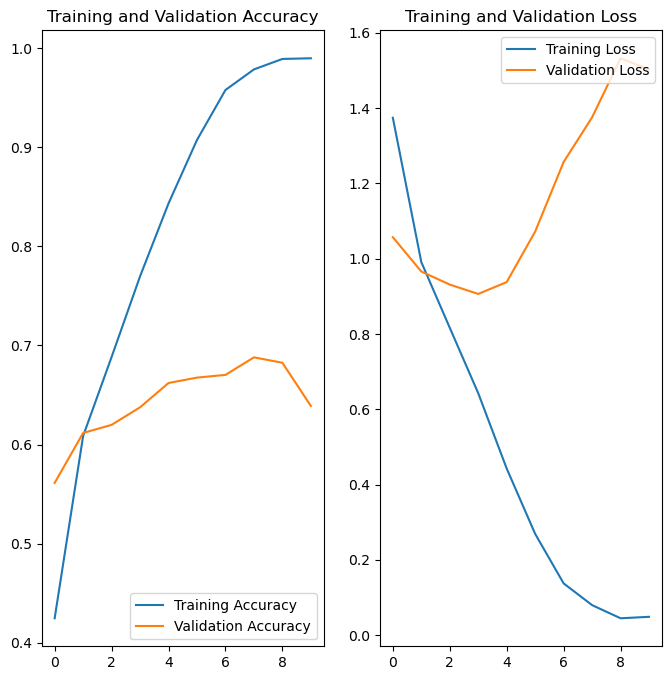

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [40]:
print(tf.__version__)

2.10.0


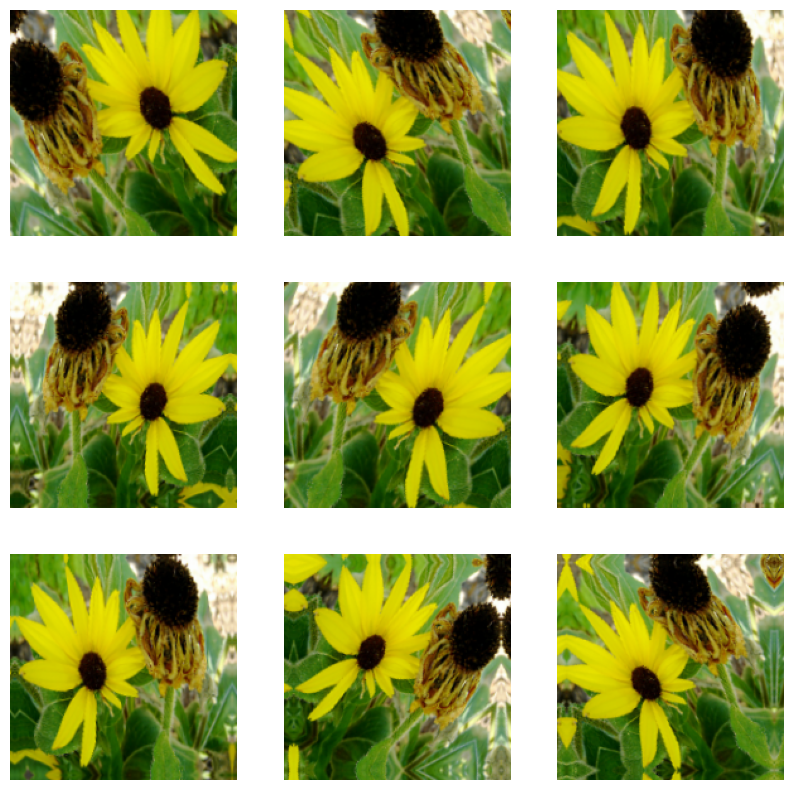

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         


 g2D)                                                            


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         


 g2D)                                                            


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3989285 (15.22 MB)


Trainable params: 3989285 (15.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2023-09-01 04:39:15.947104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/92 [..............................] - ETA: 3:29 - loss: 1.6111 - accuracy: 0.1562

 3/92 [..............................] - ETA: 3s - loss: 2.2509 - accuracy: 0.1667  

 5/92 [>.............................] - ETA: 3s - loss: 2.0633 - accuracy: 0.1776

 7/92 [=>............................] - ETA: 2s - loss: 1.9016 - accuracy: 0.2130

 9/92 [=>............................] - ETA: 2s - loss: 1.8453 - accuracy: 0.2000

11/92 [==>...........................] - ETA: 2s - loss: 1.8034 - accuracy: 0.1977

13/92 [===>..........................] - ETA: 2s - loss: 1.7672 - accuracy: 0.2279

15/92 [===>..........................] - ETA: 2s - loss: 1.7389 - accuracy: 0.2458

17/92 [====>.........................] - ETA: 2s - loss: 1.7127 - accuracy: 0.2481

19/92 [=====>........................] - ETA: 2s - loss: 1.6916 - accuracy: 0.2533

21/92 [=====>........................] - ETA: 2s - loss: 1.6757 - accuracy: 0.2590

23/92 [======>.......................] - ETA: 2s - loss: 1.6577 - accuracy: 0.2651

25/92 [=======>......................] - ETA: 1s - loss: 1.6419 - accuracy: 0.2677

27/92 [=======>......................] - ETA: 1s - loss: 1.6247 - accuracy: 0.2757

29/92 [========>.....................] - ETA: 1s - loss: 1.6129 - accuracy: 0.2815

31/92 [=========>....................] - ETA: 1s - loss: 1.5947 - accuracy: 0.2876

33/92 [=========>....................] - ETA: 1s - loss: 1.5714 - accuracy: 0.2987

35/92 [==========>...................] - ETA: 1s - loss: 1.5592 - accuracy: 0.3058

37/92 [===========>..................] - ETA: 1s - loss: 1.5434 - accuracy: 0.3155

39/92 [===========>..................] - ETA: 1s - loss: 1.5324 - accuracy: 0.3202

41/92 [============>.................] - ETA: 1s - loss: 1.5198 - accuracy: 0.3267

43/92 [=============>................] - ETA: 1s - loss: 1.5108 - accuracy: 0.3304

45/92 [=============>................] - ETA: 1s - loss: 1.5004 - accuracy: 0.3352

47/92 [==============>...............] - ETA: 1s - loss: 1.4916 - accuracy: 0.3402

49/92 [==============>...............] - ETA: 1s - loss: 1.4872 - accuracy: 0.3487

51/92 [===============>..............] - ETA: 1s - loss: 1.4766 - accuracy: 0.3547

53/92 [================>.............] - ETA: 1s - loss: 1.4681 - accuracy: 0.3572

55/92 [================>.............] - ETA: 0s - loss: 1.4571 - accuracy: 0.3636

57/92 [=================>............] - ETA: 0s - loss: 1.4502 - accuracy: 0.3651

59/92 [==================>...........] - ETA: 0s - loss: 1.4415 - accuracy: 0.3723

61/92 [==================>...........] - ETA: 0s - loss: 1.4312 - accuracy: 0.3776

63/92 [===================>..........] - ETA: 0s - loss: 1.4336 - accuracy: 0.3760

65/92 [====================>.........] - ETA: 0s - loss: 1.4257 - accuracy: 0.3760

67/92 [====================>.........] - ETA: 0s - loss: 1.4152 - accuracy: 0.3806

69/92 [=====================>........] - ETA: 0s - loss: 1.4124 - accuracy: 0.3836

71/92 [======================>.......] - ETA: 0s - loss: 1.4078 - accuracy: 0.3891

73/92 [======================>.......] - ETA: 0s - loss: 1.3989 - accuracy: 0.3943

75/92 [=======================>......] - ETA: 0s - loss: 1.3960 - accuracy: 0.3984

77/92 [========================>.....] - ETA: 0s - loss: 1.3881 - accuracy: 0.4043

79/92 [========================>.....] - ETA: 0s - loss: 1.3851 - accuracy: 0.4048

81/92 [=========================>....] - ETA: 0s - loss: 1.3810 - accuracy: 0.4067

83/92 [==========================>...] - ETA: 0s - loss: 1.3762 - accuracy: 0.4094

85/92 [==========================>...] - ETA: 0s - loss: 1.3689 - accuracy: 0.4141

87/92 [===========================>..] - ETA: 0s - loss: 1.3642 - accuracy: 0.4186

89/92 [============================>.] - ETA: 0s - loss: 1.3594 - accuracy: 0.4215

91/92 [============================>.] - ETA: 0s - loss: 1.3537 - accuracy: 0.4239

92/92 [==============================] - 5s 30ms/step - loss: 1.3504 - accuracy: 0.4251 - val_loss: 1.0968 - val_accuracy: 0.5477


Epoch 2/15


 1/92 [..............................] - ETA: 2s - loss: 1.0995 - accuracy: 0.5312

 3/92 [..............................] - ETA: 2s - loss: 0.9755 - accuracy: 0.5938

 5/92 [>.............................] - ETA: 2s - loss: 1.1514 - accuracy: 0.5500

 7/92 [=>............................] - ETA: 2s - loss: 1.0882 - accuracy: 0.5848

 9/92 [=>............................] - ETA: 2s - loss: 1.0599 - accuracy: 0.5799

11/92 [==>...........................] - ETA: 2s - loss: 1.1029 - accuracy: 0.5710

13/92 [===>..........................] - ETA: 2s - loss: 1.1076 - accuracy: 0.5577

15/92 [===>..........................] - ETA: 1s - loss: 1.1055 - accuracy: 0.5562

17/92 [====>.........................] - ETA: 1s - loss: 1.1135 - accuracy: 0.5570

19/92 [=====>........................] - ETA: 1s - loss: 1.0961 - accuracy: 0.5625

21/92 [=====>........................] - ETA: 1s - loss: 1.0950 - accuracy: 0.5610

23/92 [======>.......................] - ETA: 1s - loss: 1.0857 - accuracy: 0.5693

25/92 [=======>......................] - ETA: 1s - loss: 1.0942 - accuracy: 0.5663

27/92 [=======>......................] - ETA: 1s - loss: 1.0905 - accuracy: 0.5602

29/92 [========>.....................] - ETA: 1s - loss: 1.0941 - accuracy: 0.5550

31/92 [=========>....................] - ETA: 1s - loss: 1.0974 - accuracy: 0.5524

33/92 [=========>....................] - ETA: 1s - loss: 1.0962 - accuracy: 0.5530

35/92 [==========>...................] - ETA: 1s - loss: 1.0933 - accuracy: 0.5509

37/92 [===========>..................] - ETA: 1s - loss: 1.0880 - accuracy: 0.5541

39/92 [===========>..................] - ETA: 1s - loss: 1.0945 - accuracy: 0.5481

41/92 [============>.................] - ETA: 1s - loss: 1.0929 - accuracy: 0.5503

44/92 [=============>................] - ETA: 1s - loss: 1.0885 - accuracy: 0.5504

46/92 [==============>...............] - ETA: 1s - loss: 1.0914 - accuracy: 0.5516

48/92 [==============>...............] - ETA: 1s - loss: 1.0882 - accuracy: 0.5560

50/92 [===============>..............] - ETA: 1s - loss: 1.0888 - accuracy: 0.5537

52/92 [===============>..............] - ETA: 1s - loss: 1.0870 - accuracy: 0.5535

54/92 [================>.............] - ETA: 0s - loss: 1.0800 - accuracy: 0.5550

56/92 [=================>............] - ETA: 0s - loss: 1.0756 - accuracy: 0.5575

58/92 [=================>............] - ETA: 0s - loss: 1.0702 - accuracy: 0.5603

60/92 [==================>...........] - ETA: 0s - loss: 1.0748 - accuracy: 0.5589

62/92 [===================>..........] - ETA: 0s - loss: 1.0828 - accuracy: 0.5549

65/92 [====================>.........] - ETA: 0s - loss: 1.0799 - accuracy: 0.5596

67/92 [====================>.........] - ETA: 0s - loss: 1.0736 - accuracy: 0.5634

69/92 [=====================>........] - ETA: 0s - loss: 1.0769 - accuracy: 0.5634

71/92 [======================>.......] - ETA: 0s - loss: 1.0734 - accuracy: 0.5647

73/92 [======================>.......] - ETA: 0s - loss: 1.0689 - accuracy: 0.5672

75/92 [=======================>......] - ETA: 0s - loss: 1.0770 - accuracy: 0.5642

77/92 [========================>.....] - ETA: 0s - loss: 1.0758 - accuracy: 0.5662

79/92 [========================>.....] - ETA: 0s - loss: 1.0811 - accuracy: 0.5645

81/92 [=========================>....] - ETA: 0s - loss: 1.0738 - accuracy: 0.5687

83/92 [==========================>...] - ETA: 0s - loss: 1.0744 - accuracy: 0.5681

85/92 [==========================>...] - ETA: 0s - loss: 1.0721 - accuracy: 0.5695

88/92 [===========================>..] - ETA: 0s - loss: 1.0725 - accuracy: 0.5709

90/92 [============================>.] - ETA: 0s - loss: 1.0737 - accuracy: 0.5710

92/92 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.5736

92/92 [==============================] - 3s 28ms/step - loss: 1.0710 - accuracy: 0.5736 - val_loss: 1.0254 - val_accuracy: 0.6008


Epoch 3/15


 1/92 [..............................] - ETA: 2s - loss: 1.0994 - accuracy: 0.5625

 3/92 [..............................] - ETA: 2s - loss: 1.0743 - accuracy: 0.5729

 5/92 [>.............................] - ETA: 2s - loss: 0.9941 - accuracy: 0.6000

 7/92 [=>............................] - ETA: 2s - loss: 0.9509 - accuracy: 0.6295

 9/92 [=>............................] - ETA: 2s - loss: 0.9479 - accuracy: 0.6319

11/92 [==>...........................] - ETA: 2s - loss: 0.9566 - accuracy: 0.6222

13/92 [===>..........................] - ETA: 1s - loss: 0.9516 - accuracy: 0.6250

15/92 [===>..........................] - ETA: 1s - loss: 0.9533 - accuracy: 0.6229

18/92 [====>.........................] - ETA: 1s - loss: 0.9564 - accuracy: 0.6250

20/92 [=====>........................] - ETA: 1s - loss: 0.9447 - accuracy: 0.6313

22/92 [======>.......................] - ETA: 1s - loss: 0.9579 - accuracy: 0.6178

24/92 [======>.......................] - ETA: 1s - loss: 0.9645 - accuracy: 0.6132

26/92 [=======>......................] - ETA: 1s - loss: 0.9523 - accuracy: 0.6201

28/92 [========>.....................] - ETA: 1s - loss: 0.9569 - accuracy: 0.6160

30/92 [========>.....................] - ETA: 1s - loss: 0.9499 - accuracy: 0.6187

32/92 [=========>....................] - ETA: 1s - loss: 0.9413 - accuracy: 0.6191

34/92 [==========>...................] - ETA: 1s - loss: 0.9314 - accuracy: 0.6213

36/92 [==========>...................] - ETA: 1s - loss: 0.9446 - accuracy: 0.6145

38/92 [===========>..................] - ETA: 1s - loss: 0.9446 - accuracy: 0.6159

40/92 [============>.................] - ETA: 1s - loss: 0.9405 - accuracy: 0.6195

42/92 [============>.................] - ETA: 1s - loss: 0.9334 - accuracy: 0.6228

44/92 [=============>................] - ETA: 1s - loss: 0.9354 - accuracy: 0.6243

46/92 [==============>...............] - ETA: 1s - loss: 0.9335 - accuracy: 0.6250

48/92 [==============>...............] - ETA: 1s - loss: 0.9402 - accuracy: 0.6204

50/92 [===============>..............] - ETA: 1s - loss: 0.9431 - accuracy: 0.6206

52/92 [===============>..............] - ETA: 1s - loss: 0.9419 - accuracy: 0.6226

54/92 [================>.............] - ETA: 0s - loss: 0.9369 - accuracy: 0.6267

56/92 [=================>............] - ETA: 0s - loss: 0.9395 - accuracy: 0.6244

59/92 [==================>...........] - ETA: 0s - loss: 0.9411 - accuracy: 0.6234

61/92 [==================>...........] - ETA: 0s - loss: 0.9382 - accuracy: 0.6260

63/92 [===================>..........] - ETA: 0s - loss: 0.9370 - accuracy: 0.6270

65/92 [====================>.........] - ETA: 0s - loss: 0.9357 - accuracy: 0.6289

67/92 [====================>.........] - ETA: 0s - loss: 0.9403 - accuracy: 0.6297

69/92 [=====================>........] - ETA: 0s - loss: 0.9431 - accuracy: 0.6305

71/92 [======================>.......] - ETA: 0s - loss: 0.9450 - accuracy: 0.6277

73/92 [======================>.......] - ETA: 0s - loss: 0.9458 - accuracy: 0.6302

75/92 [=======================>......] - ETA: 0s - loss: 0.9490 - accuracy: 0.6283

77/92 [========================>.....] - ETA: 0s - loss: 0.9503 - accuracy: 0.6270

79/92 [========================>.....] - ETA: 0s - loss: 0.9513 - accuracy: 0.6274

81/92 [=========================>....] - ETA: 0s - loss: 0.9497 - accuracy: 0.6285

83/92 [==========================>...] - ETA: 0s - loss: 0.9477 - accuracy: 0.6299

85/92 [==========================>...] - ETA: 0s - loss: 0.9471 - accuracy: 0.6305

87/92 [===========================>..] - ETA: 0s - loss: 0.9481 - accuracy: 0.6290

89/92 [============================>.] - ETA: 0s - loss: 0.9447 - accuracy: 0.6310

91/92 [============================>.] - ETA: 0s - loss: 0.9467 - accuracy: 0.6295

92/92 [==============================] - 3s 28ms/step - loss: 0.9464 - accuracy: 0.6294 - val_loss: 0.9360 - val_accuracy: 0.6458


Epoch 4/15


 1/92 [..............................] - ETA: 2s - loss: 0.8777 - accuracy: 0.5938

 3/92 [..............................] - ETA: 2s - loss: 0.9324 - accuracy: 0.6667

 5/92 [>.............................] - ETA: 2s - loss: 0.8976 - accuracy: 0.6562

 7/92 [=>............................] - ETA: 2s - loss: 0.9137 - accuracy: 0.6562

 9/92 [=>............................] - ETA: 2s - loss: 0.9117 - accuracy: 0.6424

11/92 [==>...........................] - ETA: 2s - loss: 0.9148 - accuracy: 0.6278

13/92 [===>..........................] - ETA: 1s - loss: 0.9186 - accuracy: 0.6274

15/92 [===>..........................] - ETA: 1s - loss: 0.9412 - accuracy: 0.6167

18/92 [====>.........................] - ETA: 1s - loss: 0.9319 - accuracy: 0.6267

20/92 [=====>........................] - ETA: 1s - loss: 0.9327 - accuracy: 0.6266

23/92 [======>.......................] - ETA: 1s - loss: 0.9157 - accuracy: 0.6386

25/92 [=======>......................] - ETA: 1s - loss: 0.8940 - accuracy: 0.6525

27/92 [=======>......................] - ETA: 1s - loss: 0.8844 - accuracy: 0.6516

29/92 [========>.....................] - ETA: 1s - loss: 0.8924 - accuracy: 0.6552

31/92 [=========>....................] - ETA: 1s - loss: 0.8840 - accuracy: 0.6613

33/92 [=========>....................] - ETA: 1s - loss: 0.8860 - accuracy: 0.6610

35/92 [==========>...................] - ETA: 1s - loss: 0.8841 - accuracy: 0.6589

37/92 [===========>..................] - ETA: 1s - loss: 0.8869 - accuracy: 0.6588

39/92 [===========>..................] - ETA: 1s - loss: 0.8752 - accuracy: 0.6651

41/92 [============>.................] - ETA: 1s - loss: 0.8651 - accuracy: 0.6730

43/92 [=============>................] - ETA: 1s - loss: 0.8621 - accuracy: 0.6737

45/92 [=============>................] - ETA: 1s - loss: 0.8539 - accuracy: 0.6778

47/92 [==============>...............] - ETA: 1s - loss: 0.8574 - accuracy: 0.6742

50/92 [===============>..............] - ETA: 1s - loss: 0.8570 - accuracy: 0.6756

52/92 [===============>..............] - ETA: 1s - loss: 0.8630 - accuracy: 0.6737

54/92 [================>.............] - ETA: 0s - loss: 0.8598 - accuracy: 0.6759

56/92 [=================>............] - ETA: 0s - loss: 0.8608 - accuracy: 0.6752

58/92 [=================>............] - ETA: 0s - loss: 0.8651 - accuracy: 0.6746

60/92 [==================>...........] - ETA: 0s - loss: 0.8634 - accuracy: 0.6740

62/92 [===================>..........] - ETA: 0s - loss: 0.8676 - accuracy: 0.6704

64/92 [===================>..........] - ETA: 0s - loss: 0.8655 - accuracy: 0.6729

66/92 [====================>.........] - ETA: 0s - loss: 0.8658 - accuracy: 0.6714

68/92 [=====================>........] - ETA: 0s - loss: 0.8630 - accuracy: 0.6710

70/92 [=====================>........] - ETA: 0s - loss: 0.8649 - accuracy: 0.6701

72/92 [======================>.......] - ETA: 0s - loss: 0.8645 - accuracy: 0.6706

74/92 [=======================>......] - ETA: 0s - loss: 0.8687 - accuracy: 0.6685

76/92 [=======================>......] - ETA: 0s - loss: 0.8668 - accuracy: 0.6669

78/92 [========================>.....] - ETA: 0s - loss: 0.8646 - accuracy: 0.6671

80/92 [=========================>....] - ETA: 0s - loss: 0.8625 - accuracy: 0.6687

82/92 [=========================>....] - ETA: 0s - loss: 0.8646 - accuracy: 0.6681

84/92 [==========================>...] - ETA: 0s - loss: 0.8698 - accuracy: 0.6652

86/92 [===========================>..] - ETA: 0s - loss: 0.8673 - accuracy: 0.6672

88/92 [===========================>..] - ETA: 0s - loss: 0.8635 - accuracy: 0.6690

91/92 [============================>.] - ETA: 0s - loss: 0.8644 - accuracy: 0.6684

92/92 [==============================] - 3s 28ms/step - loss: 0.8627 - accuracy: 0.6696 - val_loss: 0.9086 - val_accuracy: 0.6526


Epoch 5/15


 1/92 [..............................] - ETA: 2s - loss: 0.6357 - accuracy: 0.7812

 4/92 [>.............................] - ETA: 2s - loss: 0.8291 - accuracy: 0.6797

 6/92 [>.............................] - ETA: 2s - loss: 0.8071 - accuracy: 0.7031

 8/92 [=>............................] - ETA: 2s - loss: 0.8673 - accuracy: 0.6562

11/92 [==>...........................] - ETA: 2s - loss: 0.8789 - accuracy: 0.6591

13/92 [===>..........................] - ETA: 1s - loss: 0.9055 - accuracy: 0.6538

15/92 [===>..........................] - ETA: 1s - loss: 0.9034 - accuracy: 0.6521

17/92 [====>.........................] - ETA: 1s - loss: 0.8940 - accuracy: 0.6507

19/92 [=====>........................] - ETA: 1s - loss: 0.9000 - accuracy: 0.6414

22/92 [======>.......................] - ETA: 1s - loss: 0.8715 - accuracy: 0.6520

24/92 [======>.......................] - ETA: 1s - loss: 0.8782 - accuracy: 0.6562

27/92 [=======>......................] - ETA: 1s - loss: 0.8706 - accuracy: 0.6597

29/92 [========>.....................] - ETA: 1s - loss: 0.8685 - accuracy: 0.6616

32/92 [=========>....................] - ETA: 1s - loss: 0.8792 - accuracy: 0.6562

35/92 [==========>...................] - ETA: 1s - loss: 0.8836 - accuracy: 0.6589

37/92 [===========>..................] - ETA: 1s - loss: 0.8789 - accuracy: 0.6588

39/92 [===========>..................] - ETA: 1s - loss: 0.8754 - accuracy: 0.6603

41/92 [============>.................] - ETA: 1s - loss: 0.8758 - accuracy: 0.6631

44/92 [=============>................] - ETA: 1s - loss: 0.8722 - accuracy: 0.6655

46/92 [==============>...............] - ETA: 1s - loss: 0.8834 - accuracy: 0.6596

48/92 [==============>...............] - ETA: 1s - loss: 0.8768 - accuracy: 0.6667

50/92 [===============>..............] - ETA: 1s - loss: 0.8711 - accuracy: 0.6687

52/92 [===============>..............] - ETA: 1s - loss: 0.8677 - accuracy: 0.6689

55/92 [================>.............] - ETA: 0s - loss: 0.8683 - accuracy: 0.6682

57/92 [=================>............] - ETA: 0s - loss: 0.8658 - accuracy: 0.6683

59/92 [==================>...........] - ETA: 0s - loss: 0.8615 - accuracy: 0.6684

61/92 [==================>...........] - ETA: 0s - loss: 0.8613 - accuracy: 0.6696

63/92 [===================>..........] - ETA: 0s - loss: 0.8548 - accuracy: 0.6741

65/92 [====================>.........] - ETA: 0s - loss: 0.8496 - accuracy: 0.6745

67/92 [====================>.........] - ETA: 0s - loss: 0.8422 - accuracy: 0.6786

69/92 [=====================>........] - ETA: 0s - loss: 0.8410 - accuracy: 0.6789

71/92 [======================>.......] - ETA: 0s - loss: 0.8365 - accuracy: 0.6791

73/92 [======================>.......] - ETA: 0s - loss: 0.8337 - accuracy: 0.6802

75/92 [=======================>......] - ETA: 0s - loss: 0.8280 - accuracy: 0.6812

78/92 [========================>.....] - ETA: 0s - loss: 0.8301 - accuracy: 0.6813

80/92 [=========================>....] - ETA: 0s - loss: 0.8290 - accuracy: 0.6814

83/92 [==========================>...] - ETA: 0s - loss: 0.8322 - accuracy: 0.6824

85/92 [==========================>...] - ETA: 0s - loss: 0.8314 - accuracy: 0.6818

87/92 [===========================>..] - ETA: 0s - loss: 0.8307 - accuracy: 0.6823

89/92 [============================>.] - ETA: 0s - loss: 0.8291 - accuracy: 0.6827

91/92 [============================>.] - ETA: 0s - loss: 0.8285 - accuracy: 0.6829

92/92 [==============================] - 3s 27ms/step - loss: 0.8263 - accuracy: 0.6839 - val_loss: 0.9519 - val_accuracy: 0.6649


Epoch 6/15


 1/92 [..............................] - ETA: 2s - loss: 0.7314 - accuracy: 0.7500

 3/92 [..............................] - ETA: 2s - loss: 0.8860 - accuracy: 0.7083

 5/92 [>.............................] - ETA: 2s - loss: 0.9132 - accuracy: 0.6625

 7/92 [=>............................] - ETA: 2s - loss: 0.8358 - accuracy: 0.6875

 9/92 [=>............................] - ETA: 2s - loss: 0.8228 - accuracy: 0.6736

11/92 [==>...........................] - ETA: 2s - loss: 0.7865 - accuracy: 0.6960

14/92 [===>..........................] - ETA: 1s - loss: 0.7760 - accuracy: 0.7098

16/92 [====>.........................] - ETA: 1s - loss: 0.7665 - accuracy: 0.7188

19/92 [=====>........................] - ETA: 1s - loss: 0.7431 - accuracy: 0.7286

22/92 [======>.......................] - ETA: 1s - loss: 0.7357 - accuracy: 0.7330

24/92 [======>.......................] - ETA: 1s - loss: 0.7461 - accuracy: 0.7214

27/92 [=======>......................] - ETA: 1s - loss: 0.7521 - accuracy: 0.7164

29/92 [========>.....................] - ETA: 1s - loss: 0.7579 - accuracy: 0.7134

32/92 [=========>....................] - ETA: 1s - loss: 0.7505 - accuracy: 0.7158

34/92 [==========>...................] - ETA: 1s - loss: 0.7530 - accuracy: 0.7123

37/92 [===========>..................] - ETA: 1s - loss: 0.7508 - accuracy: 0.7120

40/92 [============>.................] - ETA: 1s - loss: 0.7618 - accuracy: 0.7039

42/92 [============>.................] - ETA: 1s - loss: 0.7710 - accuracy: 0.7024

45/92 [=============>................] - ETA: 1s - loss: 0.7621 - accuracy: 0.7069

47/92 [==============>...............] - ETA: 1s - loss: 0.7683 - accuracy: 0.7008

50/92 [===============>..............] - ETA: 1s - loss: 0.7722 - accuracy: 0.6981

52/92 [===============>..............] - ETA: 0s - loss: 0.7732 - accuracy: 0.6989

54/92 [================>.............] - ETA: 0s - loss: 0.7753 - accuracy: 0.6991

56/92 [=================>............] - ETA: 0s - loss: 0.7743 - accuracy: 0.6987

59/92 [==================>...........] - ETA: 0s - loss: 0.7794 - accuracy: 0.6965

62/92 [===================>..........] - ETA: 0s - loss: 0.7794 - accuracy: 0.6966

64/92 [===================>..........] - ETA: 0s - loss: 0.7802 - accuracy: 0.6953

66/92 [====================>.........] - ETA: 0s - loss: 0.7765 - accuracy: 0.6984

69/92 [=====================>........] - ETA: 0s - loss: 0.7759 - accuracy: 0.6988

72/92 [======================>.......] - ETA: 0s - loss: 0.7775 - accuracy: 0.6988

74/92 [=======================>......] - ETA: 0s - loss: 0.7748 - accuracy: 0.7010

77/92 [========================>.....] - ETA: 0s - loss: 0.7742 - accuracy: 0.7015

79/92 [========================>.....] - ETA: 0s - loss: 0.7686 - accuracy: 0.7044

81/92 [=========================>....] - ETA: 0s - loss: 0.7684 - accuracy: 0.7036

83/92 [==========================>...] - ETA: 0s - loss: 0.7726 - accuracy: 0.7028

86/92 [===========================>..] - ETA: 0s - loss: 0.7719 - accuracy: 0.7044

88/92 [===========================>..] - ETA: 0s - loss: 0.7724 - accuracy: 0.7033

90/92 [============================>.] - ETA: 0s - loss: 0.7791 - accuracy: 0.7006

92/92 [==============================] - 2s 27ms/step - loss: 0.7752 - accuracy: 0.7020 - val_loss: 0.8381 - val_accuracy: 0.6812


Epoch 7/15


 1/92 [..............................] - ETA: 2s - loss: 0.8426 - accuracy: 0.6562

 4/92 [>.............................] - ETA: 2s - loss: 0.8704 - accuracy: 0.6833

 7/92 [=>............................] - ETA: 2s - loss: 0.9111 - accuracy: 0.6713

10/92 [==>...........................] - ETA: 1s - loss: 0.8330 - accuracy: 0.7083

12/92 [==>...........................] - ETA: 1s - loss: 0.7881 - accuracy: 0.7340

14/92 [===>..........................] - ETA: 1s - loss: 0.7790 - accuracy: 0.7250

16/92 [====>.........................] - ETA: 1s - loss: 0.7725 - accuracy: 0.7202

19/92 [=====>........................] - ETA: 1s - loss: 0.7709 - accuracy: 0.7200

21/92 [=====>........................] - ETA: 1s - loss: 0.7710 - accuracy: 0.7244

24/92 [======>.......................] - ETA: 1s - loss: 0.7510 - accuracy: 0.7250

26/92 [=======>......................] - ETA: 1s - loss: 0.7443 - accuracy: 0.7269

28/92 [========>.....................] - ETA: 1s - loss: 0.7387 - accuracy: 0.7286

31/92 [=========>....................] - ETA: 1s - loss: 0.7442 - accuracy: 0.7236

33/92 [=========>....................] - ETA: 1s - loss: 0.7537 - accuracy: 0.7185

36/92 [==========>...................] - ETA: 1s - loss: 0.7601 - accuracy: 0.7133

38/92 [===========>..................] - ETA: 1s - loss: 0.7565 - accuracy: 0.7169

40/92 [============>.................] - ETA: 1s - loss: 0.7542 - accuracy: 0.7201

42/92 [============>.................] - ETA: 1s - loss: 0.7532 - accuracy: 0.7208

44/92 [=============>................] - ETA: 1s - loss: 0.7540 - accuracy: 0.7193

46/92 [==============>...............] - ETA: 1s - loss: 0.7555 - accuracy: 0.7179

48/92 [==============>...............] - ETA: 1s - loss: 0.7519 - accuracy: 0.7219

50/92 [===============>..............] - ETA: 1s - loss: 0.7620 - accuracy: 0.7173

53/92 [================>.............] - ETA: 0s - loss: 0.7636 - accuracy: 0.7162

55/92 [================>.............] - ETA: 0s - loss: 0.7621 - accuracy: 0.7158

57/92 [=================>............] - ETA: 0s - loss: 0.7619 - accuracy: 0.7164

59/92 [==================>...........] - ETA: 0s - loss: 0.7567 - accuracy: 0.7202

61/92 [==================>...........] - ETA: 0s - loss: 0.7592 - accuracy: 0.7186

63/92 [===================>..........] - ETA: 0s - loss: 0.7525 - accuracy: 0.7211

65/92 [====================>.........] - ETA: 0s - loss: 0.7503 - accuracy: 0.7206

67/92 [====================>.........] - ETA: 0s - loss: 0.7466 - accuracy: 0.7224

69/92 [=====================>........] - ETA: 0s - loss: 0.7489 - accuracy: 0.7214

71/92 [======================>.......] - ETA: 0s - loss: 0.7488 - accuracy: 0.7208

73/92 [======================>.......] - ETA: 0s - loss: 0.7503 - accuracy: 0.7199

75/92 [=======================>......] - ETA: 0s - loss: 0.7528 - accuracy: 0.7178

77/92 [========================>.....] - ETA: 0s - loss: 0.7528 - accuracy: 0.7191

79/92 [========================>.....] - ETA: 0s - loss: 0.7530 - accuracy: 0.7187

81/92 [=========================>....] - ETA: 0s - loss: 0.7559 - accuracy: 0.7163

83/92 [==========================>...] - ETA: 0s - loss: 0.7543 - accuracy: 0.7183

85/92 [==========================>...] - ETA: 0s - loss: 0.7516 - accuracy: 0.7194

87/92 [===========================>..] - ETA: 0s - loss: 0.7519 - accuracy: 0.7190

90/92 [============================>.] - ETA: 0s - loss: 0.7523 - accuracy: 0.7190

92/92 [==============================] - 3s 27ms/step - loss: 0.7483 - accuracy: 0.7207 - val_loss: 0.8758 - val_accuracy: 0.6798


Epoch 8/15


 1/92 [..............................] - ETA: 2s - loss: 0.6686 - accuracy: 0.7188

 4/92 [>.............................] - ETA: 2s - loss: 0.6536 - accuracy: 0.7734

 6/92 [>.............................] - ETA: 2s - loss: 0.6935 - accuracy: 0.7604

 8/92 [=>............................] - ETA: 2s - loss: 0.6969 - accuracy: 0.7695

10/92 [==>...........................] - ETA: 2s - loss: 0.6945 - accuracy: 0.7688

13/92 [===>..........................] - ETA: 1s - loss: 0.7223 - accuracy: 0.7548

15/92 [===>..........................] - ETA: 1s - loss: 0.7464 - accuracy: 0.7417

17/92 [====>.........................] - ETA: 1s - loss: 0.7480 - accuracy: 0.7371

19/92 [=====>........................] - ETA: 1s - loss: 0.7549 - accuracy: 0.7286

21/92 [=====>........................] - ETA: 1s - loss: 0.7418 - accuracy: 0.7321

23/92 [======>.......................] - ETA: 1s - loss: 0.7467 - accuracy: 0.7283

25/92 [=======>......................] - ETA: 1s - loss: 0.7333 - accuracy: 0.7337

28/92 [========>.....................] - ETA: 1s - loss: 0.7357 - accuracy: 0.7277

31/92 [=========>....................] - ETA: 1s - loss: 0.7351 - accuracy: 0.7268

33/92 [=========>....................] - ETA: 1s - loss: 0.7415 - accuracy: 0.7235

35/92 [==========>...................] - ETA: 1s - loss: 0.7375 - accuracy: 0.7241

38/92 [===========>..................] - ETA: 1s - loss: 0.7432 - accuracy: 0.7237

40/92 [============>.................] - ETA: 1s - loss: 0.7421 - accuracy: 0.7234

43/92 [=============>................] - ETA: 1s - loss: 0.7331 - accuracy: 0.7260

45/92 [=============>................] - ETA: 1s - loss: 0.7320 - accuracy: 0.7250

48/92 [==============>...............] - ETA: 1s - loss: 0.7361 - accuracy: 0.7233

51/92 [===============>..............] - ETA: 1s - loss: 0.7286 - accuracy: 0.7255

53/92 [================>.............] - ETA: 0s - loss: 0.7277 - accuracy: 0.7246

56/92 [=================>............] - ETA: 0s - loss: 0.7297 - accuracy: 0.7214

58/92 [=================>............] - ETA: 0s - loss: 0.7240 - accuracy: 0.7240

61/92 [==================>...........] - ETA: 0s - loss: 0.7189 - accuracy: 0.7279

63/92 [===================>..........] - ETA: 0s - loss: 0.7186 - accuracy: 0.7266

65/92 [====================>.........] - ETA: 0s - loss: 0.7148 - accuracy: 0.7273

68/92 [=====================>........] - ETA: 0s - loss: 0.7135 - accuracy: 0.7269

70/92 [=====================>........] - ETA: 0s - loss: 0.7150 - accuracy: 0.7245

72/92 [======================>.......] - ETA: 0s - loss: 0.7095 - accuracy: 0.7265

74/92 [=======================>......] - ETA: 0s - loss: 0.7109 - accuracy: 0.7258

76/92 [=======================>......] - ETA: 0s - loss: 0.7138 - accuracy: 0.7252

78/92 [========================>.....] - ETA: 0s - loss: 0.7125 - accuracy: 0.7259

80/92 [=========================>....] - ETA: 0s - loss: 0.7129 - accuracy: 0.7245

82/92 [=========================>....] - ETA: 0s - loss: 0.7077 - accuracy: 0.7274

84/92 [==========================>...] - ETA: 0s - loss: 0.7047 - accuracy: 0.7284

86/92 [===========================>..] - ETA: 0s - loss: 0.7059 - accuracy: 0.7270

89/92 [============================>.] - ETA: 0s - loss: 0.7022 - accuracy: 0.7285

91/92 [============================>.] - ETA: 0s - loss: 0.7025 - accuracy: 0.7290

92/92 [==============================] - 3s 27ms/step - loss: 0.7019 - accuracy: 0.7289 - val_loss: 0.8137 - val_accuracy: 0.6975


Epoch 9/15


 1/92 [..............................] - ETA: 2s - loss: 0.4591 - accuracy: 0.8125

 4/92 [>.............................] - ETA: 2s - loss: 0.5556 - accuracy: 0.7734

 6/92 [>.............................] - ETA: 2s - loss: 0.5691 - accuracy: 0.7708

 8/92 [=>............................] - ETA: 2s - loss: 0.6245 - accuracy: 0.7695

10/92 [==>...........................] - ETA: 2s - loss: 0.6414 - accuracy: 0.7469

12/92 [==>...........................] - ETA: 2s - loss: 0.6565 - accuracy: 0.7318

14/92 [===>..........................] - ETA: 1s - loss: 0.6522 - accuracy: 0.7299

16/92 [====>.........................] - ETA: 1s - loss: 0.6686 - accuracy: 0.7324

19/92 [=====>........................] - ETA: 1s - loss: 0.6479 - accuracy: 0.7434

21/92 [=====>........................] - ETA: 1s - loss: 0.6798 - accuracy: 0.7336

24/92 [======>.......................] - ETA: 1s - loss: 0.6745 - accuracy: 0.7383

26/92 [=======>......................] - ETA: 1s - loss: 0.6740 - accuracy: 0.7380

28/92 [========>.....................] - ETA: 1s - loss: 0.6833 - accuracy: 0.7355

30/92 [========>.....................] - ETA: 1s - loss: 0.6921 - accuracy: 0.7333

32/92 [=========>....................] - ETA: 1s - loss: 0.6875 - accuracy: 0.7363

34/92 [==========>...................] - ETA: 1s - loss: 0.6807 - accuracy: 0.7371

36/92 [==========>...................] - ETA: 1s - loss: 0.6763 - accuracy: 0.7405

38/92 [===========>..................] - ETA: 1s - loss: 0.6754 - accuracy: 0.7434

40/92 [============>.................] - ETA: 1s - loss: 0.6732 - accuracy: 0.7453

42/92 [============>.................] - ETA: 1s - loss: 0.6682 - accuracy: 0.7478

44/92 [=============>................] - ETA: 1s - loss: 0.6699 - accuracy: 0.7464

46/92 [==============>...............] - ETA: 1s - loss: 0.6653 - accuracy: 0.7486

49/92 [==============>...............] - ETA: 1s - loss: 0.6670 - accuracy: 0.7436

51/92 [===============>..............] - ETA: 1s - loss: 0.6650 - accuracy: 0.7445

53/92 [================>.............] - ETA: 0s - loss: 0.6644 - accuracy: 0.7471

55/92 [================>.............] - ETA: 0s - loss: 0.6643 - accuracy: 0.7466

57/92 [=================>............] - ETA: 0s - loss: 0.6611 - accuracy: 0.7478

59/92 [==================>...........] - ETA: 0s - loss: 0.6617 - accuracy: 0.7463

61/92 [==================>...........] - ETA: 0s - loss: 0.6634 - accuracy: 0.7444

63/92 [===================>..........] - ETA: 0s - loss: 0.6625 - accuracy: 0.7455

65/92 [====================>.........] - ETA: 0s - loss: 0.6652 - accuracy: 0.7447

67/92 [====================>.........] - ETA: 0s - loss: 0.6721 - accuracy: 0.7407

69/92 [=====================>........] - ETA: 0s - loss: 0.6705 - accuracy: 0.7428

71/92 [======================>.......] - ETA: 0s - loss: 0.6688 - accuracy: 0.7434

73/92 [======================>.......] - ETA: 0s - loss: 0.6685 - accuracy: 0.7427

75/92 [=======================>......] - ETA: 0s - loss: 0.6761 - accuracy: 0.7404

77/92 [========================>.....] - ETA: 0s - loss: 0.6782 - accuracy: 0.7382

79/92 [========================>.....] - ETA: 0s - loss: 0.6786 - accuracy: 0.7381

82/92 [=========================>....] - ETA: 0s - loss: 0.6752 - accuracy: 0.7397

84/92 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.7425

86/92 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.7427

88/92 [===========================>..] - ETA: 0s - loss: 0.6714 - accuracy: 0.7432

90/92 [============================>.] - ETA: 0s - loss: 0.6697 - accuracy: 0.7448

92/92 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7425

92/92 [==============================] - 3s 27ms/step - loss: 0.6718 - accuracy: 0.7425 - val_loss: 0.7978 - val_accuracy: 0.6907


Epoch 10/15


 1/92 [..............................] - ETA: 2s - loss: 0.6950 - accuracy: 0.7500

 4/92 [>.............................] - ETA: 2s - loss: 0.7403 - accuracy: 0.6953

 6/92 [>.............................] - ETA: 2s - loss: 0.7548 - accuracy: 0.6979

 9/92 [=>............................] - ETA: 2s - loss: 0.6827 - accuracy: 0.7257

11/92 [==>...........................] - ETA: 2s - loss: 0.6679 - accuracy: 0.7301

14/92 [===>..........................] - ETA: 1s - loss: 0.6792 - accuracy: 0.7299

16/92 [====>.........................] - ETA: 1s - loss: 0.6597 - accuracy: 0.7422

18/92 [====>.........................] - ETA: 1s - loss: 0.6674 - accuracy: 0.7448

20/92 [=====>........................] - ETA: 1s - loss: 0.6863 - accuracy: 0.7312

22/92 [======>.......................] - ETA: 1s - loss: 0.6847 - accuracy: 0.7301

24/92 [======>.......................] - ETA: 1s - loss: 0.6821 - accuracy: 0.7292

27/92 [=======>......................] - ETA: 1s - loss: 0.6703 - accuracy: 0.7326

30/92 [========>.....................] - ETA: 1s - loss: 0.6681 - accuracy: 0.7365

32/92 [=========>....................] - ETA: 1s - loss: 0.6644 - accuracy: 0.7363

34/92 [==========>...................] - ETA: 1s - loss: 0.6543 - accuracy: 0.7390

36/92 [==========>...................] - ETA: 1s - loss: 0.6555 - accuracy: 0.7405

38/92 [===========>..................] - ETA: 1s - loss: 0.6523 - accuracy: 0.7418

40/92 [============>.................] - ETA: 1s - loss: 0.6513 - accuracy: 0.7414

42/92 [============>.................] - ETA: 1s - loss: 0.6491 - accuracy: 0.7418

44/92 [=============>................] - ETA: 1s - loss: 0.6436 - accuracy: 0.7443

46/92 [==============>...............] - ETA: 1s - loss: 0.6403 - accuracy: 0.7452

48/92 [==============>...............] - ETA: 1s - loss: 0.6415 - accuracy: 0.7461

50/92 [===============>..............] - ETA: 1s - loss: 0.6446 - accuracy: 0.7444

53/92 [================>.............] - ETA: 0s - loss: 0.6407 - accuracy: 0.7476

55/92 [================>.............] - ETA: 0s - loss: 0.6378 - accuracy: 0.7489

57/92 [=================>............] - ETA: 0s - loss: 0.6342 - accuracy: 0.7517

59/92 [==================>...........] - ETA: 0s - loss: 0.6375 - accuracy: 0.7505

61/92 [==================>...........] - ETA: 0s - loss: 0.6376 - accuracy: 0.7500

63/92 [===================>..........] - ETA: 0s - loss: 0.6405 - accuracy: 0.7485

65/92 [====================>.........] - ETA: 0s - loss: 0.6469 - accuracy: 0.7461

67/92 [====================>.........] - ETA: 0s - loss: 0.6494 - accuracy: 0.7472

69/92 [=====================>........] - ETA: 0s - loss: 0.6486 - accuracy: 0.7473

71/92 [======================>.......] - ETA: 0s - loss: 0.6584 - accuracy: 0.7429

73/92 [======================>.......] - ETA: 0s - loss: 0.6585 - accuracy: 0.7431

75/92 [=======================>......] - ETA: 0s - loss: 0.6587 - accuracy: 0.7429

77/92 [========================>.....] - ETA: 0s - loss: 0.6585 - accuracy: 0.7435

79/92 [========================>.....] - ETA: 0s - loss: 0.6596 - accuracy: 0.7437

81/92 [=========================>....] - ETA: 0s - loss: 0.6574 - accuracy: 0.7446

83/92 [==========================>...] - ETA: 0s - loss: 0.6569 - accuracy: 0.7451

85/92 [==========================>...] - ETA: 0s - loss: 0.6565 - accuracy: 0.7445

87/92 [===========================>..] - ETA: 0s - loss: 0.6534 - accuracy: 0.7457

89/92 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.7444

91/92 [============================>.] - ETA: 0s - loss: 0.6517 - accuracy: 0.7459

92/92 [==============================] - 3s 27ms/step - loss: 0.6485 - accuracy: 0.7473 - val_loss: 0.7869 - val_accuracy: 0.6962


Epoch 11/15


 1/92 [..............................] - ETA: 2s - loss: 0.6216 - accuracy: 0.7500

 4/92 [>.............................] - ETA: 2s - loss: 0.5963 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 2s - loss: 0.5685 - accuracy: 0.7917

 8/92 [=>............................] - ETA: 2s - loss: 0.6243 - accuracy: 0.7617

10/92 [==>...........................] - ETA: 2s - loss: 0.6276 - accuracy: 0.7594

12/92 [==>...........................] - ETA: 2s - loss: 0.6743 - accuracy: 0.7370

14/92 [===>..........................] - ETA: 1s - loss: 0.6759 - accuracy: 0.7388

17/92 [====>.........................] - ETA: 1s - loss: 0.6746 - accuracy: 0.7408

19/92 [=====>........................] - ETA: 1s - loss: 0.6653 - accuracy: 0.7418

22/92 [======>.......................] - ETA: 1s - loss: 0.6657 - accuracy: 0.7471

24/92 [======>.......................] - ETA: 1s - loss: 0.6785 - accuracy: 0.7408

27/92 [=======>......................] - ETA: 1s - loss: 0.6662 - accuracy: 0.7500

29/92 [========>.....................] - ETA: 1s - loss: 0.6582 - accuracy: 0.7543

32/92 [=========>....................] - ETA: 1s - loss: 0.6626 - accuracy: 0.7559

34/92 [==========>...................] - ETA: 1s - loss: 0.6690 - accuracy: 0.7509

36/92 [==========>...................] - ETA: 1s - loss: 0.6633 - accuracy: 0.7535

39/92 [===========>..................] - ETA: 1s - loss: 0.6586 - accuracy: 0.7573

41/92 [============>.................] - ETA: 1s - loss: 0.6484 - accuracy: 0.7607

44/92 [=============>................] - ETA: 1s - loss: 0.6458 - accuracy: 0.7586

46/92 [==============>...............] - ETA: 1s - loss: 0.6464 - accuracy: 0.7575

48/92 [==============>...............] - ETA: 1s - loss: 0.6449 - accuracy: 0.7592

50/92 [===============>..............] - ETA: 1s - loss: 0.6403 - accuracy: 0.7601

52/92 [===============>..............] - ETA: 0s - loss: 0.6508 - accuracy: 0.7560

54/92 [================>.............] - ETA: 0s - loss: 0.6507 - accuracy: 0.7581

56/92 [=================>............] - ETA: 0s - loss: 0.6443 - accuracy: 0.7607

58/92 [=================>............] - ETA: 0s - loss: 0.6410 - accuracy: 0.7614

60/92 [==================>...........] - ETA: 0s - loss: 0.6476 - accuracy: 0.7594

62/92 [===================>..........] - ETA: 0s - loss: 0.6497 - accuracy: 0.7586

65/92 [====================>.........] - ETA: 0s - loss: 0.6487 - accuracy: 0.7587

67/92 [====================>.........] - ETA: 0s - loss: 0.6425 - accuracy: 0.7626

69/92 [=====================>........] - ETA: 0s - loss: 0.6443 - accuracy: 0.7618

71/92 [======================>.......] - ETA: 0s - loss: 0.6425 - accuracy: 0.7624

73/92 [======================>.......] - ETA: 0s - loss: 0.6404 - accuracy: 0.7625

75/92 [=======================>......] - ETA: 0s - loss: 0.6408 - accuracy: 0.7617

77/92 [========================>.....] - ETA: 0s - loss: 0.6397 - accuracy: 0.7618

79/92 [========================>.....] - ETA: 0s - loss: 0.6392 - accuracy: 0.7623

82/92 [=========================>....] - ETA: 0s - loss: 0.6365 - accuracy: 0.7622

85/92 [==========================>...] - ETA: 0s - loss: 0.6324 - accuracy: 0.7633

87/92 [===========================>..] - ETA: 0s - loss: 0.6324 - accuracy: 0.7633

90/92 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.7639

92/92 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.7646

92/92 [==============================] - 3s 27ms/step - loss: 0.6308 - accuracy: 0.7646 - val_loss: 0.8430 - val_accuracy: 0.7016


Epoch 12/15


 1/92 [..............................] - ETA: 2s - loss: 0.4499 - accuracy: 0.8125

 4/92 [>.............................] - ETA: 2s - loss: 0.5558 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 2s - loss: 0.5312 - accuracy: 0.7969

 8/92 [=>............................] - ETA: 2s - loss: 0.5506 - accuracy: 0.7852

10/92 [==>...........................] - ETA: 2s - loss: 0.5716 - accuracy: 0.7844

12/92 [==>...........................] - ETA: 2s - loss: 0.5670 - accuracy: 0.7865

14/92 [===>..........................] - ETA: 1s - loss: 0.5693 - accuracy: 0.7812

16/92 [====>.........................] - ETA: 1s - loss: 0.5695 - accuracy: 0.7891

18/92 [====>.........................] - ETA: 1s - loss: 0.5836 - accuracy: 0.7865

20/92 [=====>........................] - ETA: 1s - loss: 0.5833 - accuracy: 0.7859

22/92 [======>.......................] - ETA: 1s - loss: 0.5984 - accuracy: 0.7827

24/92 [======>.......................] - ETA: 1s - loss: 0.6136 - accuracy: 0.7760

26/92 [=======>......................] - ETA: 1s - loss: 0.6196 - accuracy: 0.7752

28/92 [========>.....................] - ETA: 1s - loss: 0.6270 - accuracy: 0.7712

30/92 [========>.....................] - ETA: 1s - loss: 0.6166 - accuracy: 0.7771

32/92 [=========>....................] - ETA: 1s - loss: 0.6196 - accuracy: 0.7764

34/92 [==========>...................] - ETA: 1s - loss: 0.6277 - accuracy: 0.7693

36/92 [==========>...................] - ETA: 1s - loss: 0.6182 - accuracy: 0.7734

38/92 [===========>..................] - ETA: 1s - loss: 0.6192 - accuracy: 0.7738

41/92 [============>.................] - ETA: 1s - loss: 0.6187 - accuracy: 0.7745

43/92 [=============>................] - ETA: 1s - loss: 0.6276 - accuracy: 0.7675

45/92 [=============>................] - ETA: 1s - loss: 0.6247 - accuracy: 0.7654

47/92 [==============>...............] - ETA: 1s - loss: 0.6272 - accuracy: 0.7647

49/92 [==============>...............] - ETA: 1s - loss: 0.6240 - accuracy: 0.7660

51/92 [===============>..............] - ETA: 1s - loss: 0.6198 - accuracy: 0.7691

53/92 [================>.............] - ETA: 0s - loss: 0.6156 - accuracy: 0.7719

55/92 [================>.............] - ETA: 0s - loss: 0.6154 - accuracy: 0.7717

57/92 [=================>............] - ETA: 0s - loss: 0.6145 - accuracy: 0.7720

59/92 [==================>...........] - ETA: 0s - loss: 0.6166 - accuracy: 0.7723

61/92 [==================>...........] - ETA: 0s - loss: 0.6165 - accuracy: 0.7711

63/92 [===================>..........] - ETA: 0s - loss: 0.6120 - accuracy: 0.7724

65/92 [====================>.........] - ETA: 0s - loss: 0.6185 - accuracy: 0.7703

67/92 [====================>.........] - ETA: 0s - loss: 0.6228 - accuracy: 0.7697

69/92 [=====================>........] - ETA: 0s - loss: 0.6188 - accuracy: 0.7705

71/92 [======================>.......] - ETA: 0s - loss: 0.6166 - accuracy: 0.7712

73/92 [======================>.......] - ETA: 0s - loss: 0.6156 - accuracy: 0.7710

75/92 [=======================>......] - ETA: 0s - loss: 0.6167 - accuracy: 0.7701

77/92 [========================>.....] - ETA: 0s - loss: 0.6184 - accuracy: 0.7679

79/92 [========================>.....] - ETA: 0s - loss: 0.6200 - accuracy: 0.7659

81/92 [=========================>....] - ETA: 0s - loss: 0.6184 - accuracy: 0.7663

83/92 [==========================>...] - ETA: 0s - loss: 0.6161 - accuracy: 0.7670

85/92 [==========================>...] - ETA: 0s - loss: 0.6203 - accuracy: 0.7636

87/92 [===========================>..] - ETA: 0s - loss: 0.6179 - accuracy: 0.7655

89/92 [============================>.] - ETA: 0s - loss: 0.6172 - accuracy: 0.7651

91/92 [============================>.] - ETA: 0s - loss: 0.6137 - accuracy: 0.7658

92/92 [==============================] - 3s 27ms/step - loss: 0.6119 - accuracy: 0.7663 - val_loss: 0.7812 - val_accuracy: 0.7125


Epoch 13/15


 1/92 [..............................] - ETA: 2s - loss: 0.5050 - accuracy: 0.7812

 3/92 [..............................] - ETA: 2s - loss: 0.6552 - accuracy: 0.7604

 5/92 [>.............................] - ETA: 2s - loss: 0.5960 - accuracy: 0.7750

 7/92 [=>............................] - ETA: 2s - loss: 0.6061 - accuracy: 0.7679

 9/92 [=>............................] - ETA: 2s - loss: 0.6384 - accuracy: 0.7465

11/92 [==>...........................] - ETA: 2s - loss: 0.6278 - accuracy: 0.7500

13/92 [===>..........................] - ETA: 2s - loss: 0.6276 - accuracy: 0.7500

15/92 [===>..........................] - ETA: 1s - loss: 0.6149 - accuracy: 0.7625

17/92 [====>.........................] - ETA: 1s - loss: 0.6160 - accuracy: 0.7665

19/92 [=====>........................] - ETA: 1s - loss: 0.6046 - accuracy: 0.7697

21/92 [=====>........................] - ETA: 1s - loss: 0.5952 - accuracy: 0.7738

23/92 [======>.......................] - ETA: 1s - loss: 0.5825 - accuracy: 0.7785

25/92 [=======>......................] - ETA: 1s - loss: 0.5817 - accuracy: 0.7800

27/92 [=======>......................] - ETA: 1s - loss: 0.5753 - accuracy: 0.7824

29/92 [========>.....................] - ETA: 1s - loss: 0.5689 - accuracy: 0.7845

32/92 [=========>....................] - ETA: 1s - loss: 0.5760 - accuracy: 0.7805

34/92 [==========>...................] - ETA: 1s - loss: 0.5798 - accuracy: 0.7787

36/92 [==========>...................] - ETA: 1s - loss: 0.5769 - accuracy: 0.7788

38/92 [===========>..................] - ETA: 1s - loss: 0.5815 - accuracy: 0.7781

40/92 [============>.................] - ETA: 1s - loss: 0.5788 - accuracy: 0.7767

42/92 [============>.................] - ETA: 1s - loss: 0.5825 - accuracy: 0.7762

44/92 [=============>................] - ETA: 1s - loss: 0.5830 - accuracy: 0.7779

46/92 [==============>...............] - ETA: 1s - loss: 0.5782 - accuracy: 0.7807

48/92 [==============>...............] - ETA: 1s - loss: 0.5825 - accuracy: 0.7781

50/92 [===============>..............] - ETA: 1s - loss: 0.5824 - accuracy: 0.7789

52/92 [===============>..............] - ETA: 1s - loss: 0.5820 - accuracy: 0.7808

54/92 [================>.............] - ETA: 0s - loss: 0.5925 - accuracy: 0.7762

56/92 [=================>............] - ETA: 0s - loss: 0.5907 - accuracy: 0.7769

58/92 [=================>............] - ETA: 0s - loss: 0.5937 - accuracy: 0.7749

60/92 [==================>...........] - ETA: 0s - loss: 0.5908 - accuracy: 0.7772

62/92 [===================>..........] - ETA: 0s - loss: 0.5866 - accuracy: 0.7799

64/92 [===================>..........] - ETA: 0s - loss: 0.5862 - accuracy: 0.7799

66/92 [====================>.........] - ETA: 0s - loss: 0.5884 - accuracy: 0.7785

69/92 [=====================>........] - ETA: 0s - loss: 0.5876 - accuracy: 0.7791

71/92 [======================>.......] - ETA: 0s - loss: 0.5868 - accuracy: 0.7792

73/92 [======================>.......] - ETA: 0s - loss: 0.5876 - accuracy: 0.7779

75/92 [=======================>......] - ETA: 0s - loss: 0.5893 - accuracy: 0.7763

77/92 [========================>.....] - ETA: 0s - loss: 0.5866 - accuracy: 0.7761

79/92 [========================>.....] - ETA: 0s - loss: 0.5869 - accuracy: 0.7762

81/92 [=========================>....] - ETA: 0s - loss: 0.5876 - accuracy: 0.7740

84/92 [==========================>...] - ETA: 0s - loss: 0.5869 - accuracy: 0.7754

86/92 [===========================>..] - ETA: 0s - loss: 0.5903 - accuracy: 0.7726

88/92 [===========================>..] - ETA: 0s - loss: 0.5912 - accuracy: 0.7699

90/92 [============================>.] - ETA: 0s - loss: 0.5921 - accuracy: 0.7702

92/92 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.7701

92/92 [==============================] - 3s 28ms/step - loss: 0.5898 - accuracy: 0.7701 - val_loss: 0.7424 - val_accuracy: 0.7193


Epoch 14/15


 1/92 [..............................] - ETA: 2s - loss: 0.3620 - accuracy: 0.9062

 3/92 [..............................] - ETA: 2s - loss: 0.4677 - accuracy: 0.8021

 5/92 [>.............................] - ETA: 2s - loss: 0.4568 - accuracy: 0.8313

 7/92 [=>............................] - ETA: 2s - loss: 0.4432 - accuracy: 0.8393

 9/92 [=>............................] - ETA: 2s - loss: 0.4669 - accuracy: 0.8229

11/92 [==>...........................] - ETA: 2s - loss: 0.4695 - accuracy: 0.8210

13/92 [===>..........................] - ETA: 2s - loss: 0.4991 - accuracy: 0.8029

15/92 [===>..........................] - ETA: 1s - loss: 0.5021 - accuracy: 0.7979

17/92 [====>.........................] - ETA: 1s - loss: 0.5099 - accuracy: 0.7923

19/92 [=====>........................] - ETA: 1s - loss: 0.5144 - accuracy: 0.7845

21/92 [=====>........................] - ETA: 1s - loss: 0.5248 - accuracy: 0.7783

23/92 [======>.......................] - ETA: 1s - loss: 0.5237 - accuracy: 0.7799

25/92 [=======>......................] - ETA: 1s - loss: 0.5467 - accuracy: 0.7750

27/92 [=======>......................] - ETA: 1s - loss: 0.5539 - accuracy: 0.7743

29/92 [========>.....................] - ETA: 1s - loss: 0.5556 - accuracy: 0.7759

31/92 [=========>....................] - ETA: 1s - loss: 0.5626 - accuracy: 0.7712

33/92 [=========>....................] - ETA: 1s - loss: 0.5578 - accuracy: 0.7746

35/92 [==========>...................] - ETA: 1s - loss: 0.5586 - accuracy: 0.7777

37/92 [===========>..................] - ETA: 1s - loss: 0.5481 - accuracy: 0.7838

39/92 [===========>..................] - ETA: 1s - loss: 0.5464 - accuracy: 0.7861

41/92 [============>.................] - ETA: 1s - loss: 0.5439 - accuracy: 0.7873

43/92 [=============>................] - ETA: 1s - loss: 0.5466 - accuracy: 0.7885

45/92 [=============>................] - ETA: 1s - loss: 0.5429 - accuracy: 0.7917

47/92 [==============>...............] - ETA: 1s - loss: 0.5425 - accuracy: 0.7919

49/92 [==============>...............] - ETA: 1s - loss: 0.5475 - accuracy: 0.7895

51/92 [===============>..............] - ETA: 1s - loss: 0.5447 - accuracy: 0.7904

53/92 [================>.............] - ETA: 0s - loss: 0.5453 - accuracy: 0.7901

55/92 [================>.............] - ETA: 0s - loss: 0.5403 - accuracy: 0.7932

57/92 [=================>............] - ETA: 0s - loss: 0.5342 - accuracy: 0.7955

59/92 [==================>...........] - ETA: 0s - loss: 0.5386 - accuracy: 0.7956

61/92 [==================>...........] - ETA: 0s - loss: 0.5411 - accuracy: 0.7946

63/92 [===================>..........] - ETA: 0s - loss: 0.5407 - accuracy: 0.7946

66/92 [====================>.........] - ETA: 0s - loss: 0.5424 - accuracy: 0.7942

68/92 [=====================>........] - ETA: 0s - loss: 0.5444 - accuracy: 0.7938

70/92 [=====================>........] - ETA: 0s - loss: 0.5422 - accuracy: 0.7957

72/92 [======================>.......] - ETA: 0s - loss: 0.5531 - accuracy: 0.7918

74/92 [=======================>......] - ETA: 0s - loss: 0.5539 - accuracy: 0.7915

76/92 [=======================>......] - ETA: 0s - loss: 0.5575 - accuracy: 0.7908

78/92 [========================>.....] - ETA: 0s - loss: 0.5575 - accuracy: 0.7902

80/92 [=========================>....] - ETA: 0s - loss: 0.5587 - accuracy: 0.7888

82/92 [=========================>....] - ETA: 0s - loss: 0.5537 - accuracy: 0.7917

84/92 [==========================>...] - ETA: 0s - loss: 0.5542 - accuracy: 0.7910

86/92 [===========================>..] - ETA: 0s - loss: 0.5525 - accuracy: 0.7915

88/92 [===========================>..] - ETA: 0s - loss: 0.5528 - accuracy: 0.7917

90/92 [============================>.] - ETA: 0s - loss: 0.5567 - accuracy: 0.7914

92/92 [==============================] - 3s 28ms/step - loss: 0.5554 - accuracy: 0.7905 - val_loss: 0.7431 - val_accuracy: 0.7030


Epoch 15/15


 1/92 [..............................] - ETA: 2s - loss: 0.4821 - accuracy: 0.8750

 4/92 [>.............................] - ETA: 2s - loss: 0.5566 - accuracy: 0.8203

 6/92 [>.............................] - ETA: 2s - loss: 0.5972 - accuracy: 0.8177

 8/92 [=>............................] - ETA: 2s - loss: 0.5953 - accuracy: 0.7969

10/92 [==>...........................] - ETA: 2s - loss: 0.5759 - accuracy: 0.8031

13/92 [===>..........................] - ETA: 1s - loss: 0.5309 - accuracy: 0.8245

15/92 [===>..........................] - ETA: 1s - loss: 0.5449 - accuracy: 0.8146

17/92 [====>.........................] - ETA: 1s - loss: 0.5382 - accuracy: 0.8125

19/92 [=====>........................] - ETA: 1s - loss: 0.5318 - accuracy: 0.8158

21/92 [=====>........................] - ETA: 1s - loss: 0.5275 - accuracy: 0.8125

24/92 [======>.......................] - ETA: 1s - loss: 0.5207 - accuracy: 0.8112

26/92 [=======>......................] - ETA: 1s - loss: 0.5246 - accuracy: 0.8101

28/92 [========>.....................] - ETA: 1s - loss: 0.5496 - accuracy: 0.7969

30/92 [========>.....................] - ETA: 1s - loss: 0.5415 - accuracy: 0.8000

32/92 [=========>....................] - ETA: 1s - loss: 0.5454 - accuracy: 0.7998

34/92 [==========>...................] - ETA: 1s - loss: 0.5430 - accuracy: 0.8015

36/92 [==========>...................] - ETA: 1s - loss: 0.5410 - accuracy: 0.7986

38/92 [===========>..................] - ETA: 1s - loss: 0.5470 - accuracy: 0.7985

40/92 [============>.................] - ETA: 1s - loss: 0.5447 - accuracy: 0.8016

42/92 [============>.................] - ETA: 1s - loss: 0.5383 - accuracy: 0.8036

44/92 [=============>................] - ETA: 1s - loss: 0.5334 - accuracy: 0.8054

46/92 [==============>...............] - ETA: 1s - loss: 0.5323 - accuracy: 0.8043

48/92 [==============>...............] - ETA: 1s - loss: 0.5250 - accuracy: 0.8079

50/92 [===============>..............] - ETA: 1s - loss: 0.5267 - accuracy: 0.8081

52/92 [===============>..............] - ETA: 1s - loss: 0.5225 - accuracy: 0.8095

54/92 [================>.............] - ETA: 0s - loss: 0.5183 - accuracy: 0.8102

56/92 [=================>............] - ETA: 0s - loss: 0.5211 - accuracy: 0.8086

58/92 [=================>............] - ETA: 0s - loss: 0.5222 - accuracy: 0.8077

60/92 [==================>...........] - ETA: 0s - loss: 0.5195 - accuracy: 0.8083

62/92 [===================>..........] - ETA: 0s - loss: 0.5220 - accuracy: 0.8080

64/92 [===================>..........] - ETA: 0s - loss: 0.5207 - accuracy: 0.8066

66/92 [====================>.........] - ETA: 0s - loss: 0.5188 - accuracy: 0.8068

68/92 [=====================>........] - ETA: 0s - loss: 0.5209 - accuracy: 0.8047

70/92 [=====================>........] - ETA: 0s - loss: 0.5153 - accuracy: 0.8071

72/92 [======================>.......] - ETA: 0s - loss: 0.5203 - accuracy: 0.8060

74/92 [=======================>......] - ETA: 0s - loss: 0.5238 - accuracy: 0.8049

76/92 [=======================>......] - ETA: 0s - loss: 0.5228 - accuracy: 0.8059

79/92 [========================>.....] - ETA: 0s - loss: 0.5257 - accuracy: 0.8040

81/92 [=========================>....] - ETA: 0s - loss: 0.5300 - accuracy: 0.8022

83/92 [==========================>...] - ETA: 0s - loss: 0.5323 - accuracy: 0.7998

85/92 [==========================>...] - ETA: 0s - loss: 0.5341 - accuracy: 0.7976

87/92 [===========================>..] - ETA: 0s - loss: 0.5351 - accuracy: 0.7961

89/92 [============================>.] - ETA: 0s - loss: 0.5373 - accuracy: 0.7958

92/92 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7950

92/92 [==============================] - 3s 28ms/step - loss: 0.5384 - accuracy: 0.7950 - val_loss: 0.7529 - val_accuracy: 0.7262


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

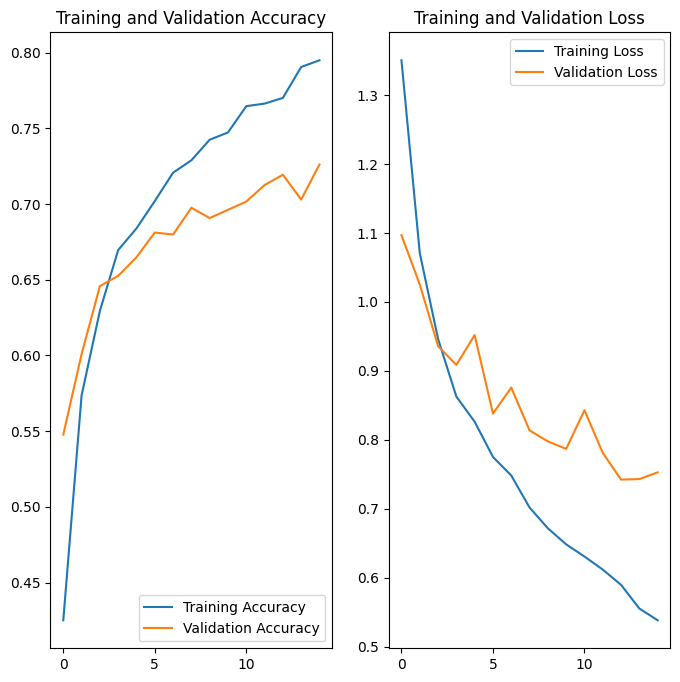

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

117948/117948 [==============================] - 0s 0us/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 179ms/step


This image most likely belongs to sunflowers with a 88.39 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp0pw9g03x/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp0pw9g03x/assets


2023-09-01 04:39:58.541508: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-09-01 04:39:58.541547: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 88.39 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.1920929e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).